# Agentic Router Evaluation 

### Analysis

1. **Quality Comparison** - Mean quality scores vs. baselines, quality by category
2. **Routing Decisions Analysis** - Model selection patterns, score distributions, pipeline reasoning
3. **Latency Analysis** - Total latency including routing overhead
4. **Cost Analysis** - Routing costs + inference costs vs. baselines
5. **Pipeline Coherence** - Do intermediate scores make sense? Full pipeline traces

In [ ]:
# Cell 1: Setup and Imports

import sys
import os
from pathlib import Path
import asyncio
import time
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Tuple
from collections import defaultdict
from dotenv import load_dotenv
from importlib import reload

# Add parent directory to path
notebook_dir = Path().resolve()
project_root = notebook_dir.parent
sys.path.insert(0, str(project_root))

# Load environment variables from .env file (if exists)
env_path = project_root / ".env"
if env_path.exists():
    load_dotenv(env_path)
    print(f"✓ Loaded .env from {env_path}")
else:
    load_dotenv() # Load from current directory if .env not in root
    print("✓ Attempted to load .env from current directory")

# Get API key from environment (it should now be loaded from .env or explicitly set above)
api_key = os.getenv("OPENROUTER_API_KEY")

# Disable LangSmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_API_KEY"] = "" 

# Enable debug mode to capture pipeline traces
os.environ["ROUTER_DEBUG"] = "1"

# --- RELOAD MODULES TO PICK UP LATEST API KEY ---
import src.config
reload(src.config) # Reload src.config to get the latest OPENROUTER_API_KEY from os.environ

# Import from src.config AFTER it's updated
from src.config import OPENROUTER_API_KEY, OPENROUTER_BASE_URL

# Import and reload all solutions2 modules that depend on src.config
# This ensures their module-level variables (like HEADERS in llm_client.py) are refreshed
import solutions.llm_client
import solutions.pipeline_steps
import solutions.pipeline
import solutions.custom_router

reload(solutions.llm_client)
reload(solutions.pipeline_steps)
reload(solutions.pipeline)
reload(solutions.custom_router)

# Import top-level modules after reloads
from src.router import BaseRouter, NaiveRouter, StaticRouter
from src.benchmarking import (
    benchmark_router,
    SAMPLE_QUERIES,
    RoutingBenchmarkResult,
    print_benchmark_summary,
    print_router_comparison
)
from src.model_registry import MODEL_REGISTRY, ModelTier
from solutions import CustomRouter # Re-import to use the reloaded version

# Imports for TLS certificates
import ssl
import certifi
import requests
import urllib3

# Disable SSL warnings (optional, only if you trust the connection)
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Set requests to use certifi's certificate bundle
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()
os.environ['SSL_CERT_FILE'] = certifi.where()

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Setup complete")
print(f"✓ Using queries: {sum(len(q) for q in SAMPLE_QUERIES.values())} total queries")

# Verify API key
if not OPENROUTER_API_KEY:
    print("\n⚠️  WARNING: OPENROUTER_API_KEY not set!")
    print("   Please ensure it's set in your .env file or uncomment/update the line above.")
else:
    print(f"✓ OpenRouter API key verified: {OPENROUTER_API_KEY[:10]}...{OPENROUTER_API_KEY[-4:]}")
    print(f"✓ TLS certificates configured")


✓ Attempted to load .env from current directory
✓ src.config.OPENROUTER_API_KEY after reload: sk-or-v1-0...e576
✓ Setup complete
✓ Using queries: 5 total queries
✓ OpenRouter API key verified: sk-or-v1-0...e576
✓ TLS certificates configured


## Step 0: Run Benchmarks

First, we need to benchmark all routers to get the data for analysis.

This will:
- Route queries through each router
- Make actual API calls to get responses
- Evaluate quality of responses
- Track latency and costs

In [2]:
# Configuration
EVALUATOR_MODEL = "trinity-mini"
MAX_CONCURRENT = 3
SEED = 42

# Initialize results dictionary (shared across cells)
# This will be populated by each benchmark cell
all_results = {}

print("=" * 80)
print("CONFIGURATION")
print("=" * 80)
print(f"Evaluator Model: {EVALUATOR_MODEL}")
print(f"Max Concurrent: {MAX_CONCURRENT}")
print(f"Seed: {SEED}")
print()
print("💡 Each benchmark cell will initialize its own router.")
print("💡 Run each benchmark cell separately to avoid rate limits.")
print()

CONFIGURATION
Evaluator Model: trinity-mini
Max Concurrent: 3
Seed: 42

💡 Each benchmark cell will initialize its own router.
💡 Run each benchmark cell separately to avoid rate limits.



In [16]:
# Benchmark NaiveRouter
print("=" * 80)
print("BENCHMARKING: NaiveRouter")
print("=" * 80)
print()

# Initialize router
print("Initializing NaiveRouter...")
naive_router = NaiveRouter(edge_probability=0.5)
print(f"✓ NaiveRouter: {naive_router.name}")
print()

# Run benchmark
naive_results = await benchmark_router(
    router=naive_router,
    queries=SAMPLE_QUERIES,
    evaluator_model=EVALUATOR_MODEL,
    seed=SEED,
    max_concurrent=MAX_CONCURRENT
)
all_results["NaiveRouter"] = naive_results

print(f"\n✓ NaiveRouter complete: {len(naive_results)} results")

BENCHMARKING: NaiveRouter

Initializing NaiveRouter...
✓ NaiveRouter: Random

  Phase 1: Running inference...
  [simple] gemma-3-4b@cloud: latency=1893ms
  [moderate] trinity-mini@cloud: latency=5002ms
  [reasoning] gemma-3n-e4b@edge: latency=1218ms
  [complex] gemma-3n-e4b@edge: latency=4912ms
  [coding] llama-3.2-3b@cloud: latency=46359ms
  Phase 2: Batch evaluating 5 responses...
    Evaluating batch 1/1 (5 items)...
  [simple] gemma-3-4b@cloud: quality=6.0/10
  [moderate] trinity-mini@cloud: quality=5.0/10
  [complex] gemma-3n-e4b@edge: quality=5.0/10
  [reasoning] gemma-3n-e4b@edge: quality=7.0/10
  [coding] llama-3.2-3b@cloud: quality=5.0/10

✓ NaiveRouter complete: 5 results


In [27]:
# Benchmark StaticRouter (small)
print("=" * 80)
print("BENCHMARKING: StaticRouter (small)")
print("=" * 80)
print()

# Initialize router
print("Initializing StaticRouter (small)...")
static_router_small = StaticRouter("gemma-3-4b")  # SMALL tier
print(f"✓ StaticRouter (small): {static_router_small.name}")
print()

# Run benchmark
static_small_results = await benchmark_router(
    router=static_router_small,
    queries=SAMPLE_QUERIES,
    evaluator_model=EVALUATOR_MODEL,
    seed=SEED,
    max_concurrent=MAX_CONCURRENT
)
all_results["StaticRouter (small)"] = static_small_results

print(f"\n✓ StaticRouter (small) complete: {len(static_small_results)} results")

BENCHMARKING: StaticRouter (small)

Initializing StaticRouter (small)...
✓ StaticRouter (small): Static(gemma-3-4b@edge)

  Phase 1: Running inference...
  [simple] gemma-3-4b@edge: latency=403ms
  [reasoning] gemma-3-4b@edge: latency=951ms
  [complex] gemma-3-4b@edge: latency=4373ms
  [moderate] gemma-3-4b@edge: latency=4802ms
  [coding] gemma-3-4b@edge: latency=4617ms
  Phase 2: Batch evaluating 5 responses...
    Evaluating batch 1/1 (5 items)...
  [simple] gemma-3-4b@edge: quality=8.0/10
  [moderate] gemma-3-4b@edge: quality=6.0/10
  [complex] gemma-3-4b@edge: quality=8.0/10
  [reasoning] gemma-3-4b@edge: quality=5.0/10
  [coding] gemma-3-4b@edge: quality=6.0/10

✓ StaticRouter (small) complete: 5 results


In [42]:
# Benchmark CustomRouter (AgenticRouter)
print("=" * 80)
print("BENCHMARKING: CustomRouter (AgenticRouter)")
print("=" * 80)
print()

# Initialize router
print("Initializing CustomRouter...")
custom_router = CustomRouter()
print(f"✓ CustomRouter: {custom_router.name}")
print()

# Store custom router instance for later analysis (it has trace_history)
_custom_router_instance = custom_router

# Run benchmark
custom_results = await benchmark_router(
    router=custom_router,
    queries=SAMPLE_QUERIES,
    evaluator_model=EVALUATOR_MODEL,
    seed=SEED,
    max_concurrent=MAX_CONCURRENT
)
all_results["AgenticRouter"] = custom_results

print(f"\n✓ CustomRouter complete: {len(custom_results)} results")
print("\n✓ All benchmarks complete!")

BENCHMARKING: CustomRouter (AgenticRouter)

Initializing CustomRouter...
✓ CustomRouter: AgenticRouter

  Phase 1: Running inference...
  [simple] gemma-3-4b@edge: latency=3579ms
  [reasoning] gemma-3-12b@cloud: latency=7950ms


[INTENT_CLASSIFICATION] API Error: Rate limit exceeded: free-models-per-min. 
[INTENT_CLASSIFICATION] Error code: 429
[INTENT_CLASSIFICATION] Rate limited. Waiting until reset (9.7s)...
[INTENT_CLASSIFICATION] Retry attempt 2/3


  [complex] gemma-3-12b@cloud: latency=35727ms
  [moderate] gemma-3-4b@edge: latency=8819ms
  [coding] gemma-3-12b@cloud: latency=25003ms
  Phase 2: Batch evaluating 5 responses...
    Evaluating batch 1/1 (5 items)...
  [simple] gemma-3-4b@edge: quality=7.0/10
  [moderate] gemma-3-4b@edge: quality=7.0/10
  [complex] gemma-3-12b@cloud: quality=5.0/10
  [reasoning] gemma-3-12b@cloud: quality=9.0/10
  [coding] gemma-3-12b@cloud: quality=9.0/10

✓ CustomRouter complete: 5 results

✓ All benchmarks complete!


In [43]:
# Verify All Results (Optional - run this to check progress)
print("=" * 80)
print("BENCHMARK SUMMARY")
print("=" * 80)
print()

for router_name, results in all_results.items():
    print(f"{router_name}: {len(results)} results")
    if results:
        quality_scores = [r.quality_score for r in results if r.quality_score is not None]
        if quality_scores:
            avg_quality = sum(quality_scores) / len(quality_scores)
            print(f"  Average quality: {avg_quality:.2f}/10")
        else:
            print(f"  Quality scores: None (batch evaluation may have failed)")
    print()

BENCHMARK SUMMARY

NaiveRouter: 5 results
  Average quality: 5.60/10

AgenticRouter: 5 results
  Average quality: 7.40/10

StaticRouter (small): 5 results
  Average quality: 6.60/10



## Experiment 1: Quality Comparison

**Goal**: Compare the quality of responses from our router vs baselines.

**What we're measuring**:
- Mean quality score across all queries
- Quality scores broken down by query category
- Visualizations to see patterns

**Why this matters**: A router is only good if it selects models that produce high-quality responses.

EXPERIMENT 1: QUALITY COMPARISON

1.1 Overall Mean Quality Scores:
--------------------------------------------------------------------------------
  AgenticRouter            : 7.40/10
  StaticRouter (small)     : 6.60/10
  NaiveRouter              : 5.60/10

1.2 Quality by Query Category:
--------------------------------------------------------------------------------
category              coding  complex  moderate  reasoning  simple
router                                                            
AgenticRouter            9.0      5.0       7.0        9.0     7.0
NaiveRouter              5.0      5.0       5.0        7.0     6.0
StaticRouter (small)     6.0      8.0       6.0        5.0     8.0



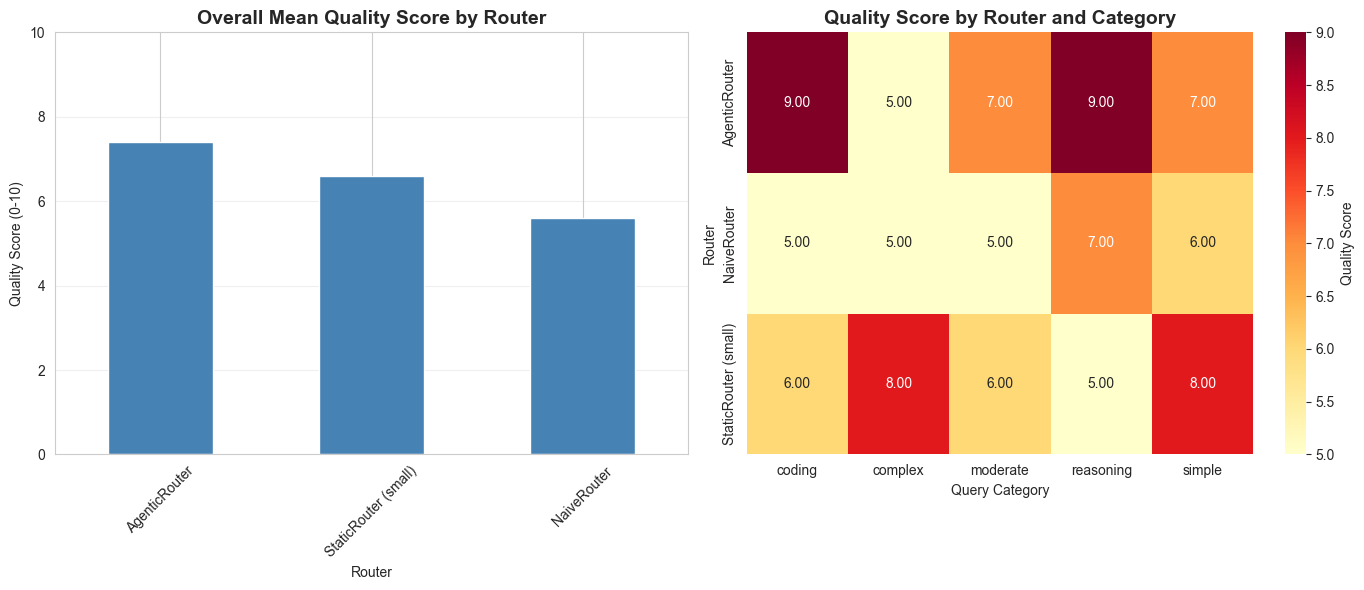

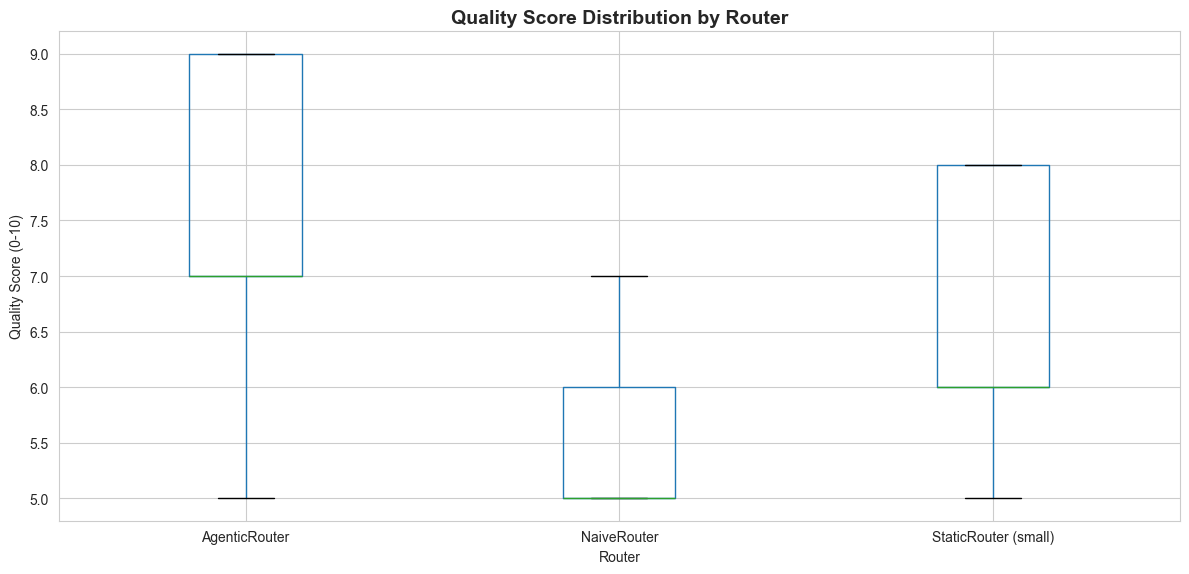

✓ Quality comparison complete!


In [44]:
print("=" * 80)
print("EXPERIMENT 1: QUALITY COMPARISON")
print("=" * 80)
print()

# Extract quality scores
quality_data = []
for router_name, results in all_results.items():
    for result in results:
        if result.quality_score is not None:
            quality_data.append({
                "router": router_name,
                "category": result.query_category,
                "quality_score": result.quality_score,
                "query": result.query[:50] + "..." if len(result.query) > 50 else result.query
            })

df_quality = pd.DataFrame(quality_data)

if not df_quality.empty:
    # Overall mean quality by router
    print("1.1 Overall Mean Quality Scores:")
    print("-" * 80)
    overall_means = df_quality.groupby("router")["quality_score"].mean().sort_values(ascending=False)
    for router, score in overall_means.items():
        print(f"  {router:<25}: {score:.2f}/10")
    print()
    
    # Quality by category
    print("1.2 Quality by Query Category:")
    print("-" * 80)
    category_means = df_quality.groupby(["router", "category"])["quality_score"].mean().unstack()
    print(category_means.round(2))
    print()
    
    # Visualization 1: Overall quality comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Bar chart of overall means
    overall_means.plot(kind="bar", ax=axes[0], color="steelblue")
    axes[0].set_title("Overall Mean Quality Score by Router", fontsize=14, fontweight="bold")
    axes[0].set_ylabel("Quality Score (0-10)")
    axes[0].set_xlabel("Router")
    axes[0].set_ylim(0, 10)
    axes[0].grid(axis="y", alpha=0.3)
    axes[0].tick_params(axis="x", rotation=45)
    
    # Heatmap of quality by category
    sns.heatmap(category_means, annot=True, fmt=".2f", cmap="YlOrRd", ax=axes[1], cbar_kws={"label": "Quality Score"})
    axes[1].set_title("Quality Score by Router and Category", fontsize=14, fontweight="bold")
    axes[1].set_xlabel("Query Category")
    axes[1].set_ylabel("Router")
    
    plt.tight_layout()
    plt.show()
    
    # Box plot for distribution
    fig, ax = plt.subplots(figsize=(12, 6))
    df_quality.boxplot(column="quality_score", by="router", ax=ax)
    ax.set_title("Quality Score Distribution by Router", fontsize=14, fontweight="bold")
    ax.set_xlabel("Router")
    ax.set_ylabel("Quality Score (0-10)")
    plt.suptitle("")  # Remove default title
    plt.tight_layout()
    plt.show()
    
    print("✓ Quality comparison complete!")
else:
    print("⚠️  No quality scores available. Make sure benchmarks completed successfully.")

## Experiment 2: Routing Decisions Analysis

**Goal**: Understand what routing decisions our agentic router makes.

**What we're measuring**:
- Which models are selected for each query category?
- How do mission/latency scores distribute across query types?
- Can we see the reasoning behind decisions?

**Why this matters**: We want to verify that the router is making intelligent, context-aware decisions that vary appropriately with query characteristics.

In [57]:
print("=" * 80)
print("EXPERIMENT 2: ROUTING DECISIONS ANALYSIS")
print("=" * 80)
print()

# 2.1: Model selection by category
print("2.1 Model Selection by Category:")
print("-" * 80)

# Get routing decisions from CustomRouter results
custom_results_df = pd.DataFrame([
    {
        "category": r.query_category,
        "model_key": r.model_key,
        "deployment": r.deployment,
        "model_tier": r.model_tier.value,
        "query": r.query[:50] + "..." if len(r.query) > 50 else r.query
    }
    for r in custom_results
])

model_by_category = custom_results_df.groupby(["category", "model_key", "deployment"]).size().unstack(fill_value=0)
print(model_by_category)
print()


EXPERIMENT 2: ROUTING DECISIONS ANALYSIS

2.1 Model Selection by Category:
--------------------------------------------------------------------------------
deployment             cloud  edge
category  model_key               
coding    gemma-3-12b      1     0
complex   gemma-3-12b      1     0
moderate  gemma-3-4b       0     1
reasoning gemma-3-12b      1     0
simple    gemma-3-4b       0     1



2.2 Mission and Latency Scores Distribution:
--------------------------------------------------------------------------------


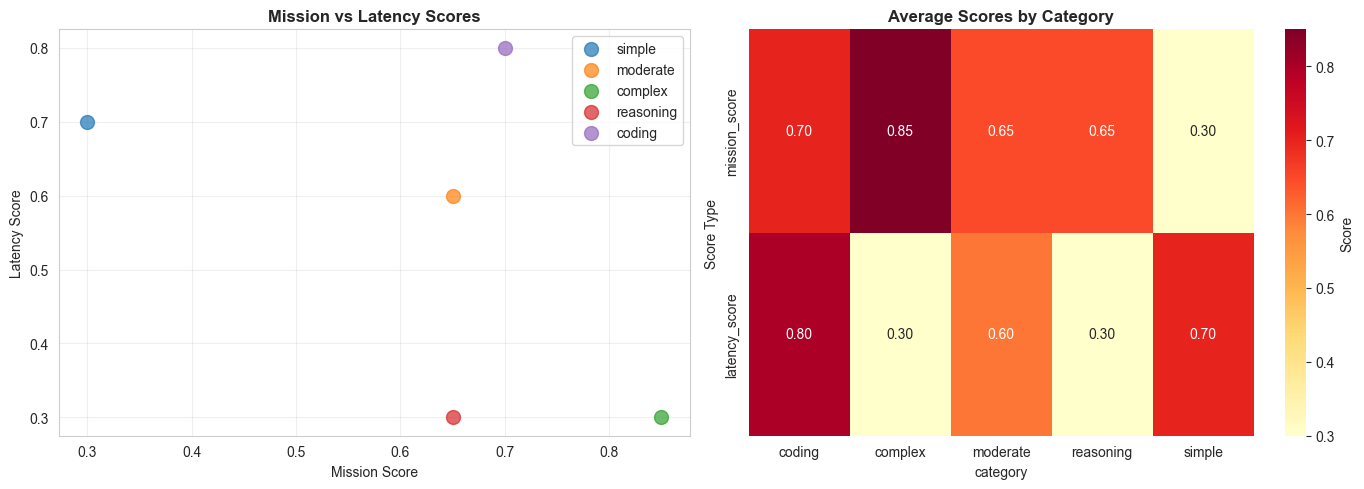

In [56]:
# 2.2: Mission/Latency scores distribution
print("2.2 Mission and Latency Scores Distribution:")
print("-" * 80)

# Extract scores from trace_history
scores_data = []
for trace in _custom_router_instance.trace_history:
    if trace.get("mission_score") is not None and trace.get("latency_score") is not None:
        # Find corresponding category from query
        query = trace["query"]
        category = None
        for cat, queries in SAMPLE_QUERIES.items():
            if query in queries:
                category = cat
                break
        
        if category:
            scores_data.append({
                "category": category,
                "mission_score": trace["mission_score"],
                "latency_score": trace["latency_score"],
                "query": query[:50] + "..." if len(query) > 50 else query
            })

if scores_data:
    df_scores = pd.DataFrame(scores_data)
    
    # Create figure with 1 row, 2 columns (instead of 2x2)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot: Mission vs Latency
    for category in df_scores["category"].unique():
        cat_data = df_scores[df_scores["category"] == category]
        axes[0].scatter(cat_data["mission_score"], cat_data["latency_score"], 
                      label=category, alpha=0.7, s=100)
    axes[0].set_xlabel("Mission Score")
    axes[0].set_ylabel("Latency Score")
    axes[0].set_title("Mission vs Latency Scores", fontweight="bold")
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Heatmap of average scores by category
    score_pivot = df_scores.groupby("category")[["mission_score", "latency_score"]].mean()
    sns.heatmap(score_pivot.T, annot=True, fmt=".2f", cmap="YlOrRd", ax=axes[1], cbar_kws={"label": "Score"})
    axes[1].set_title("Average Scores by Category", fontweight="bold")
    axes[1].set_ylabel("Score Type")
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No score data available from trace_history")

In [47]:
# 2.3: Pipeline reasoning examples
print("2.3 Pipeline Reasoning Examples:")
print("-" * 80)
print("Showing full pipeline traces for different query types...")
print()

# Show examples from each category
for category in ["simple", "moderate", "complex", "reasoning", "coding"]:
    # Find a trace for this category
    for trace in _custom_router_instance.trace_history:
        query = trace["query"]
        if any(query in queries for queries in SAMPLE_QUERIES.get(category, [])):
            print(f"\n{'='*80}")
            print(f"Category: {category}")
            print(f"Query: {query}")
            print(f"{'='*80}")
            
            if trace.get("intent"):
                intent = trace["intent"]
                print(f"\n[1] Intent Classification:")
                print(f"    Intent: {intent.intent.value}")
                print(f"    Confidence: {intent.confidence:.2f}")
                print(f"    Reasoning: {intent.reasoning}")
            
            print(f"\n[2] Mission Criticality:")
            print(f"    Score: {trace.get('mission_score', 'N/A'):.2f}/1.0")
            
            print(f"\n[3] Latency Criticality:")
            print(f"    Score: {trace.get('latency_score', 'N/A'):.2f}/1.0")
            
            if trace.get("decision"):
                decision = trace["decision"]
                print(f"\n[4] Routing Decision:")
                print(f"    Model: {decision.model_key}")
                print(f"    Deployment: {decision.deployment}")
                print(f"    Reasoning: {decision.reasoning}")
            
            print(f"\n[5] Routing Metrics:")
            print(f"    Overhead: {trace.get('routing_overhead_ms', 0):.2f}ms")
            print(f"    Cost: ${trace.get('routing_cost', 0):.6f}")
            
            break  # Only show one example per category

print("\n✓ Routing decisions analysis complete!")

2.3 Pipeline Reasoning Examples:
--------------------------------------------------------------------------------
Showing full pipeline traces for different query types...


Category: simple
Query: What color do you get when you mix red and blue?

[1] Intent Classification:
    Intent: simple_factual
    Confidence: 0.95
    Reasoning: The query is a straightforward question about a common color mixing result.

[2] Mission Criticality:
    Score: 0.30/1.0

[3] Latency Criticality:
    Score: 0.70/1.0

[4] Routing Decision:
    Model: gemma-3-4b
    Deployment: edge
    Reasoning: Low mission score, high latency: selected SMALL tier on edge for speed.

[5] Routing Metrics:
    Overhead: 8260.98ms
    Cost: $0.000144

Category: moderate
Query: How does a blockchain work and what are its main use cases?

[1] Intent Classification:
    Intent: multi_hop_factual
    Confidence: 0.85
    Reasoning: The query asks for both a definition and use cases, requiring multiple pieces of information.


## Experiment 3: Latency Analysis

**Goal**: Understand the latency characteristics of our router.

**What we're measuring**:
- Total latency = routing overhead + inference latency
- How much time is spent in the pipeline itself?
- How does routing overhead compare to inference latency?

**Why this matters**: Routing overhead adds latency. We need to ensure the overhead is acceptable compared to the benefits of better routing.

In [48]:
print("=" * 80)
print("EXPERIMENT 3: LATENCY ANALYSIS")
print("=" * 80)
print()

# 3.1: Extract latency data
latency_data = []
for router_name, results in all_results.items():
    for result in results:
        latency_data.append({
            "router": router_name,
            "category": result.query_category,
            "total_latency_ms": result.latency_ms,
            "query": result.query[:50] + "..." if len(result.query) > 50 else result.query
        })

df_latency = pd.DataFrame(latency_data)

# For CustomRouter, add routing overhead
custom_latency_data = []
for i, result in enumerate(custom_results):
    trace = _custom_router_instance.trace_history[i] if i < len(_custom_router_instance.trace_history) else {}
    custom_latency_data.append({
        "router": "AgenticRouter",
        "category": result.query_category,
        "total_latency_ms": result.latency_ms,
        "routing_overhead_ms": trace.get("routing_overhead_ms", 0),
        "inference_latency_ms": result.latency_ms - trace.get("routing_overhead_ms", 0),
        "query": result.query[:50] + "..." if len(result.query) > 50 else result.query
    })

df_custom_latency = pd.DataFrame(custom_latency_data)

# 3.2: Overall latency comparison
print("3.1 Overall Latency Comparison:")
print("-" * 80)
overall_latency = df_latency.groupby("router")["total_latency_ms"].agg(["mean", "std", "min", "max"])
print(overall_latency.round(2))
print()

# 3.3: Routing overhead breakdown for CustomRouter
if not df_custom_latency.empty:
    print("3.2 Routing Overhead Breakdown (AgenticRouter):")
    print("-" * 80)
    overhead_stats = df_custom_latency[["routing_overhead_ms", "inference_latency_ms"]].describe()
    print(overhead_stats.round(2))
    print()
    
    print("Routing Overhead as % of Total Latency:")
    df_custom_latency["overhead_pct"] = (
        df_custom_latency["routing_overhead_ms"] / df_custom_latency["total_latency_ms"] * 100
    )
    print(f"  Mean: {df_custom_latency['overhead_pct'].mean():.2f}%")
    print(f"  Min: {df_custom_latency['overhead_pct'].min():.2f}%")
    print(f"  Max: {df_custom_latency['overhead_pct'].max():.2f}%")
    print()

EXPERIMENT 3: LATENCY ANALYSIS

3.1 Overall Latency Comparison:
--------------------------------------------------------------------------------
                          mean       std      min       max
router                                                     
AgenticRouter         16215.30  13607.18  3578.85  35726.59
NaiveRouter           11876.93  19352.67  1217.85  46359.41
StaticRouter (small)   3029.16   2161.48   402.86   4802.46

3.2 Routing Overhead Breakdown (AgenticRouter):
--------------------------------------------------------------------------------
       routing_overhead_ms  inference_latency_ms
count                 5.00                  5.00
mean              10094.27               6121.03
std                4133.59              12662.37
min                7800.22              -4682.13
25%                8260.98               -623.33
50%                8365.92               1018.49
75%                8572.91               7531.43
max               17471.32       

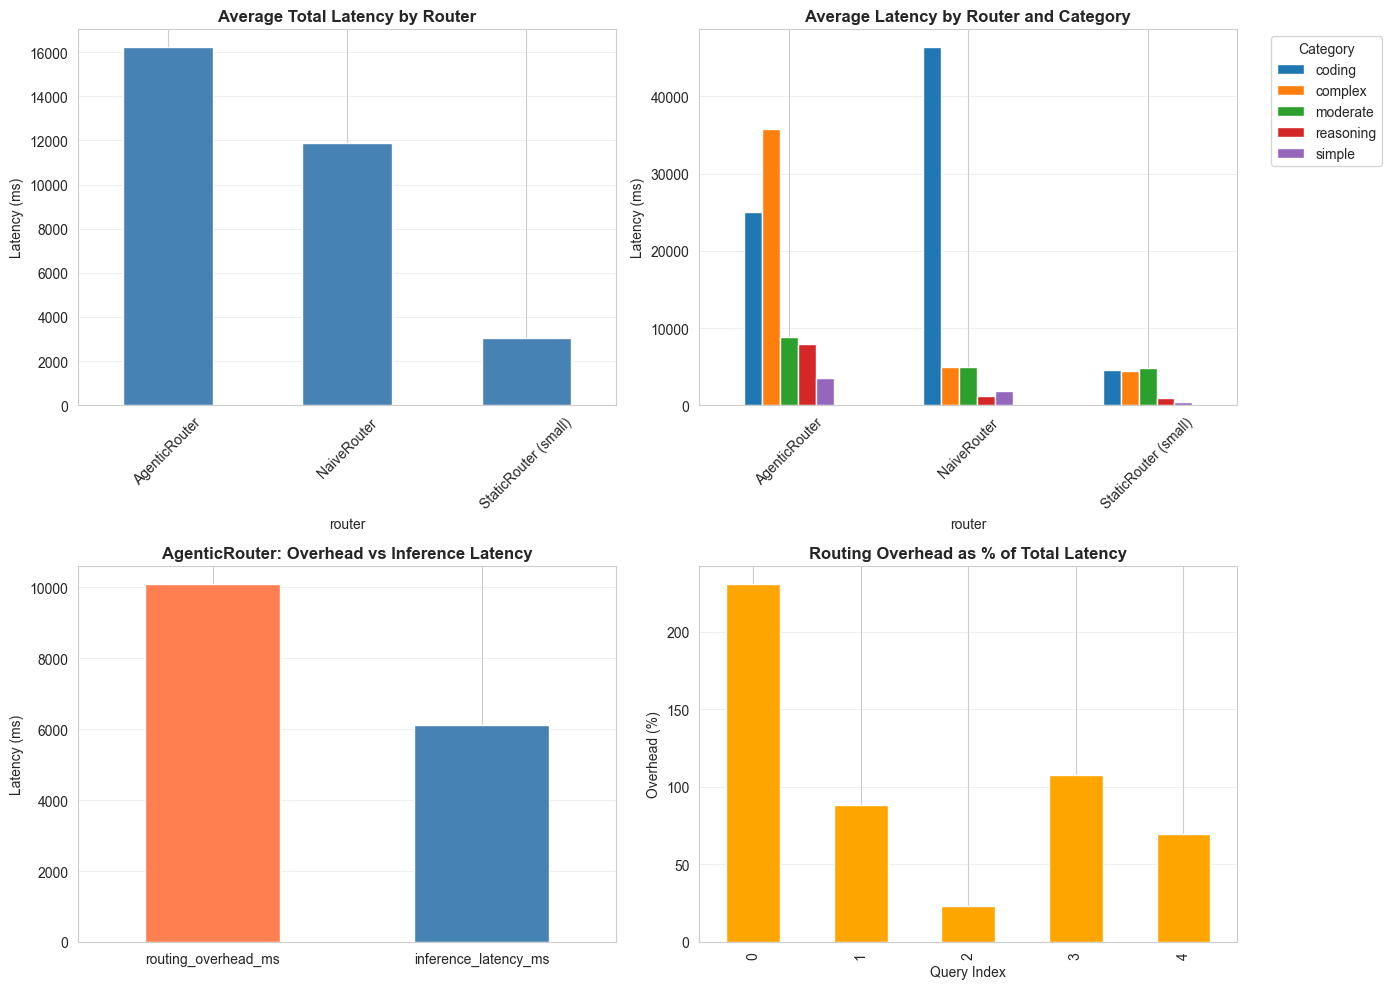

✓ Latency analysis complete!


In [49]:
# 3.4: Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall latency comparison
overall_latency["mean"].plot(kind="bar", ax=axes[0, 0], color="steelblue")
axes[0, 0].set_title("Average Total Latency by Router", fontweight="bold")
axes[0, 0].set_ylabel("Latency (ms)")
axes[0, 0].tick_params(axis="x", rotation=45)
axes[0, 0].grid(axis="y", alpha=0.3)

# Latency by category
latency_by_category = df_latency.groupby(["router", "category"])["total_latency_ms"].mean().unstack()
latency_by_category.plot(kind="bar", ax=axes[0, 1])
axes[0, 1].set_title("Average Latency by Router and Category", fontweight="bold")
axes[0, 1].set_ylabel("Latency (ms)")
axes[0, 1].legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[0, 1].tick_params(axis="x", rotation=45)
axes[0, 1].grid(axis="y", alpha=0.3)

# Routing overhead breakdown (stacked bar)
if not df_custom_latency.empty:
    overhead_breakdown = df_custom_latency[["routing_overhead_ms", "inference_latency_ms"]].mean()
    overhead_breakdown.plot(kind="bar", ax=axes[1, 0], color=["coral", "steelblue"])
    axes[1, 0].set_title("AgenticRouter: Overhead vs Inference Latency", fontweight="bold")
    axes[1, 0].set_ylabel("Latency (ms)")
    axes[1, 0].tick_params(axis="x", rotation=0)
    axes[1, 0].grid(axis="y", alpha=0.3)
    
    # Overhead percentage
    df_custom_latency["overhead_pct"].plot(kind="bar", ax=axes[1, 1], color="orange")
    axes[1, 1].set_title("Routing Overhead as % of Total Latency", fontweight="bold")
    axes[1, 1].set_ylabel("Overhead (%)")
    axes[1, 1].set_xlabel("Query Index")
    axes[1, 1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Latency analysis complete!")

## Experiment 4: Cost Analysis

**Goal**: Understand the cost structure of our router.

**What we're measuring**:
- Cost of routing (the 4 LLM calls in the pipeline)
- Cost of inference (the actual model calls)
- Total cost vs baselines

**Why this matters**: Routing adds cost. We need to ensure the benefits outweigh the additional routing costs.

In [50]:
print("=" * 80)
print("EXPERIMENT 4: COST ANALYSIS")
print("=" * 80)
print()

# 4.1: Extract cost data
cost_data = []
for router_name, results in all_results.items():
    for result in results:
        cost_data.append({
            "router": router_name,
            "category": result.query_category,
            "inference_cost": result.cost_estimate,
            "query": result.query[:50] + "..." if len(result.query) > 50 else result.query
        })

df_cost = pd.DataFrame(cost_data)

# For CustomRouter, add routing costs
for i, result in enumerate(custom_results):
    trace = _custom_router_instance.trace_history[i] if i < len(_custom_router_instance.trace_history) else {}
    # Match by query prefix
    query_prefix = result.query[:30]
    mask = (df_cost["router"] == "AgenticRouter") & (df_cost["query"].str.startswith(query_prefix))
    if mask.any():
        df_cost.loc[mask, "routing_cost"] = trace.get("routing_cost", 0)

df_cost["routing_cost"] = df_cost["routing_cost"].fillna(0)
df_cost["total_cost"] = df_cost["inference_cost"] + df_cost["routing_cost"]

# 4.2: Overall cost comparison
print("4.1 Overall Cost Comparison:")
print("-" * 80)
overall_cost = df_cost.groupby("router").agg({
    "inference_cost": "sum",
    "routing_cost": "sum",
    "total_cost": "sum"
})
print(overall_cost.round(6))
print()

# 4.3: Cost breakdown for AgenticRouter
agentic_costs = df_cost[df_cost["router"] == "AgenticRouter"]
if not agentic_costs.empty:
    print("4.2 AgenticRouter Cost Breakdown:")
    print("-" * 80)
    print(f"  Total Routing Cost: ${agentic_costs['routing_cost'].sum():.6f}")
    print(f"  Total Inference Cost: ${agentic_costs['inference_cost'].sum():.6f}")
    print(f"  Total Cost: ${agentic_costs['total_cost'].sum():.6f}")
    routing_pct = (agentic_costs['routing_cost'].sum() / agentic_costs['total_cost'].sum() * 100) if agentic_costs['total_cost'].sum() > 0 else 0
    print(f"  Routing Cost as % of Total: {routing_pct:.2f}%")
    print()

# 4.4: Cost by category
print("4.3 Cost by Query Category:")
print("-" * 80)
cost_by_category = df_cost.groupby(["router", "category"])["total_cost"].sum().unstack()
print(cost_by_category.round(6))
print()

EXPERIMENT 4: COST ANALYSIS

4.1 Overall Cost Comparison:
--------------------------------------------------------------------------------
                      inference_cost  routing_cost  total_cost
router                                                        
AgenticRouter               0.000014      0.000745    0.000759
NaiveRouter                 0.000442      0.000000    0.000442
StaticRouter (small)        0.000008      0.000000    0.000008

4.2 AgenticRouter Cost Breakdown:
--------------------------------------------------------------------------------
  Total Routing Cost: $0.000745
  Total Inference Cost: $0.000014
  Total Cost: $0.000759
  Routing Cost as % of Total: 98.20%

4.3 Cost by Query Category:
--------------------------------------------------------------------------------
category                coding   complex  moderate  reasoning    simple
router                                                                 
AgenticRouter         0.000147  0.000147  0.00014

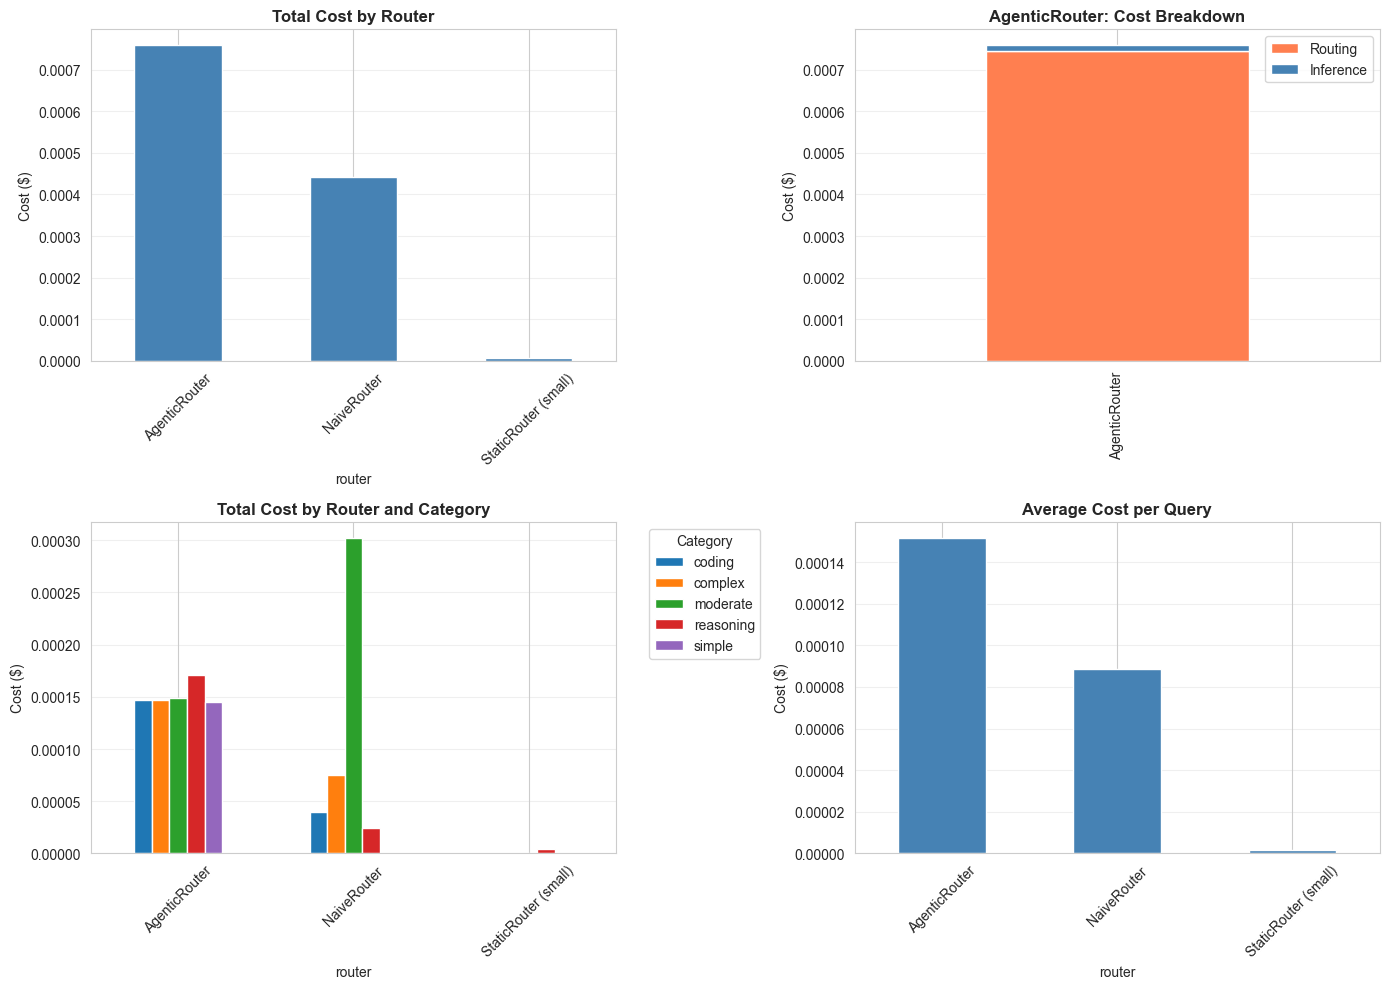

✓ Cost analysis complete!


In [51]:
# 4.5: Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total cost comparison
overall_cost["total_cost"].plot(kind="bar", ax=axes[0, 0], color="steelblue")
axes[0, 0].set_title("Total Cost by Router", fontweight="bold")
axes[0, 0].set_ylabel("Cost ($)")
axes[0, 0].tick_params(axis="x", rotation=45)
axes[0, 0].grid(axis="y", alpha=0.3)

# Cost breakdown for AgenticRouter
if not agentic_costs.empty:
    cost_breakdown = pd.DataFrame({
        "Routing": [agentic_costs["routing_cost"].sum()],
        "Inference": [agentic_costs["inference_cost"].sum()]
    })
    cost_breakdown.plot(kind="bar", stacked=True, ax=axes[0, 1], color=["coral", "steelblue"])
    axes[0, 1].set_title("AgenticRouter: Cost Breakdown", fontweight="bold")
    axes[0, 1].set_ylabel("Cost ($)")
    axes[0, 1].set_xlabel("")
    axes[0, 1].set_xticklabels(["AgenticRouter"])
    axes[0, 1].legend()
    axes[0, 1].grid(axis="y", alpha=0.3)

# Cost by category
cost_by_category.plot(kind="bar", ax=axes[1, 0])
axes[1, 0].set_title("Total Cost by Router and Category", fontweight="bold")
axes[1, 0].set_ylabel("Cost ($)")
axes[1, 0].legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
axes[1, 0].tick_params(axis="x", rotation=45)
axes[1, 0].grid(axis="y", alpha=0.3)

# Cost per query comparison
cost_per_query = df_cost.groupby("router")["total_cost"].mean()
cost_per_query.plot(kind="bar", ax=axes[1, 1], color="steelblue")
axes[1, 1].set_title("Average Cost per Query", fontweight="bold")
axes[1, 1].set_ylabel("Cost ($)")
axes[1, 1].tick_params(axis="x", rotation=45)
axes[1, 1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Cost analysis complete!")

## Experiment 5: Pipeline Coherence

**Goal**: Verify that the intermediate scores and decisions make intuitive sense.

**What we're measuring**:
- Do mission/latency scores align with query characteristics?
- Are routing decisions consistent with the scores?
- Can we trace through examples and understand the reasoning?

**Why this matters**: If the pipeline produces incoherent or counterintuitive scores, it suggests the prompts or model need improvement.

In [52]:
print("=" * 80)
print("EXPERIMENT 5: PIPELINE COHERENCE")
print("=" * 80)
print()

# 5.1: Analyze score coherence
print("5.1 Score Coherence Analysis:")
print("-" * 80)

coherence_data = []
for trace in _custom_router_instance.trace_history:
    if trace.get("mission_score") is not None and trace.get("latency_score") is not None:
        query = trace["query"]
        category = None
        for cat, queries in SAMPLE_QUERIES.items():
            if query in queries:
                category = cat
                break
        
        if category and trace.get("decision"):
            decision = trace["decision"]
            model_config = MODEL_REGISTRY.get(decision.model_key)
            coherence_data.append({
                "category": category,
                "query": query[:50] + "..." if len(query) > 50 else query,
                "mission_score": trace["mission_score"],
                "latency_score": trace["latency_score"],
                "model_tier": model_config.tier.value if model_config else "unknown",
                "deployment": decision.deployment,
                "intent": trace.get("intent").intent.value if trace.get("intent") else "unknown"
            })

df_coherence = pd.DataFrame(coherence_data)

if not df_coherence.empty:
    # Check if high mission scores lead to higher tier models
    print("Mission Score vs Model Tier:")
    print(df_coherence.groupby("model_tier")["mission_score"].mean().round(2))
    print()
    
    # Check if high latency scores lead to edge deployment
    print("Latency Score vs Deployment:")
    print(df_coherence.groupby("deployment")["latency_score"].mean().round(2))
    print()
    
    # Check intent vs model selection
    print("Intent vs Model Tier:")
    print(df_coherence.groupby(["intent", "model_tier"]).size().unstack(fill_value=0))
    print()

EXPERIMENT 5: PIPELINE COHERENCE

5.1 Score Coherence Analysis:
--------------------------------------------------------------------------------
Mission Score vs Model Tier:
model_tier
medium    0.73
small     0.48
Name: mission_score, dtype: float64

Latency Score vs Deployment:
deployment
cloud    0.47
edge     0.65
Name: latency_score, dtype: float64

Intent vs Model Tier:
model_tier         medium  small
intent                          
coding                  1      0
complex_reasoning       2      0
multi_hop_factual       0      1
simple_factual          0      1



In [53]:
# 5.2: Full pipeline traces for different query types
print("5.2 Full Pipeline Traces by Query Type:")
print("-" * 80)
print()

# Show detailed traces for one example from each category
for category in ["simple", "moderate", "complex", "reasoning", "coding"]:
    for trace in _custom_router_instance.trace_history:
        query = trace["query"]
        if any(query in queries for queries in SAMPLE_QUERIES.get(category, [])):
            print(f"\n{'='*80}")
            print(f"CATEGORY: {category.upper()}")
            print(f"{'='*80}")
            print(f"\nQuery: {query}")
            print(f"\n{'─'*80}")
            
            # Intent
            if trace.get("intent"):
                intent = trace["intent"]
                print(f"\n[STEP 1] Intent Classification:")
                print(f"  • Intent: {intent.intent.value}")
                print(f"  • Confidence: {intent.confidence:.2f}")
                print(f"  • Reasoning: {intent.reasoning}")
            
            # Mission
            print(f"\n[STEP 2] Mission Criticality:")
            print(f"  • Score: {trace.get('mission_score', 'N/A'):.2f}/1.0")
            if trace.get("full_state") and trace["full_state"].get("mission_criticality"):
                print(f"  • Reasoning: {trace['full_state']['mission_criticality'].reasoning}")
            
            # Latency
            print(f"\n[STEP 3] Latency Criticality:")
            print(f"  • Score: {trace.get('latency_score', 'N/A'):.2f}/1.0")
            if trace.get("full_state") and trace["full_state"].get("latency_criticality"):
                print(f"  • Reasoning: {trace['full_state']['latency_criticality'].reasoning}")
            
            # Decision
            if trace.get("decision"):
                decision = trace["decision"]
                print(f"\n[STEP 4] Routing Decision:")
                print(f"  • Selected Model: {decision.model_key}")
                print(f"  • Deployment: {decision.deployment}")
                print(f"  • Reasoning: {decision.reasoning}")
                
                # Check if decision makes sense
                model_config = MODEL_REGISTRY.get(decision.model_key)
                if model_config:
                    print(f"  • Model Tier: {model_config.tier.value}")
                    print(f"  • Decision Analysis:")
                    mission = trace.get("mission_score", 0)
                    latency = trace.get("latency_score", 0)
                    
                    if mission >= 0.8:
                        print(f"    ✓ High mission score ({mission:.2f}) → Should use higher tier model")
                        if model_config.tier.value in ["large", "reasoning"]:
                            print(f"    ✓ Correctly selected {model_config.tier.value} tier")
                        else:
                            print(f"    ⚠️  Selected {model_config.tier.value} tier (might need higher tier)")
                    
                    if latency >= 0.7 and mission <= 0.5:
                        print(f"    ✓ High latency ({latency:.2f}), low mission ({mission:.2f}) → Should use edge")
                        if decision.deployment == "edge":
                            print(f"    ✓ Correctly selected edge deployment")
                        else:
                            print(f"    ⚠️  Selected cloud (might need edge)")
            
            # Metrics
            print(f"\n[METRICS]")
            print(f"  • Routing Overhead: {trace.get('routing_overhead_ms', 0):.2f}ms")
            print(f"  • Routing Cost: ${trace.get('routing_cost', 0):.6f}")
            if trace.get("step_timings"):
                print(f"  • Step Timings:")
                for step, timing in trace["step_timings"].items():
                    print(f"      - {step}: {timing:.2f}ms")
            
            print(f"\n{'='*80}\n")
            break  # Only show one example per category

print("✓ Pipeline coherence analysis complete!")

5.2 Full Pipeline Traces by Query Type:
--------------------------------------------------------------------------------


CATEGORY: SIMPLE

Query: What color do you get when you mix red and blue?

────────────────────────────────────────────────────────────────────────────────

[STEP 1] Intent Classification:
  • Intent: simple_factual
  • Confidence: 0.95
  • Reasoning: The query is a straightforward question about a common color mixing result.

[STEP 2] Mission Criticality:
  • Score: 0.30/1.0
  • Reasoning: Incorrect answer is harmless; a simple, exploratory factual question.

[STEP 3] Latency Criticality:
  • Score: 0.70/1.0
  • Reasoning: User seeks a quick factual answer to a common question.

[STEP 4] Routing Decision:
  • Selected Model: gemma-3-4b
  • Deployment: edge
  • Reasoning: Low mission score, high latency: selected SMALL tier on edge for speed.
  • Model Tier: small
  • Decision Analysis:
    ✓ High latency (0.70), low mission (0.30) → Should use edge
    ✓ Correctly

In [54]:
print("=" * 80)
print("SUMMARY AND CONCLUSIONS")
print("=" * 80)
print()

# Get routing metrics
metrics = _custom_router_instance.get_routing_metrics()

print("AgenticRouter Performance Summary:")
print("-" * 80)
print(f"  Total Queries Routed: {metrics['total_queries']}")
print(f"  Average Routing Overhead: {metrics['avg_routing_overhead_ms']:.2f}ms")
print(f"  Total Routing Cost: ${metrics['total_routing_cost']:.6f}")
print(f"  Average Routing Cost per Query: ${metrics['avg_routing_cost_per_query']:.6f}")
print()

if metrics['step_timings_avg']:
    print("  Average Step Timings:")
    for step, timing in metrics['step_timings_avg'].items():
        print(f"    - {step}: {timing:.2f}ms")
    print()

# Compare with baselines
print("Comparison with Baselines:")
print("-" * 80)

# Quality
if not df_quality.empty:
    agentic_quality = df_quality[df_quality["router"] == "AgenticRouter"]["quality_score"].mean()
    naive_quality = df_quality[df_quality["router"] == "NaiveRouter"]["quality_score"].mean()
    print(f"  Quality Score:")
    print(f"    AgenticRouter: {agentic_quality:.2f}/10")
    print(f"    NaiveRouter: {naive_quality:.2f}/10")
    print(f"    Improvement: {agentic_quality - naive_quality:+.2f} points")
    print()

# Latency
agentic_latency = df_latency[df_latency["router"] == "AgenticRouter"]["total_latency_ms"].mean()
naive_latency = df_latency[df_latency["router"] == "NaiveRouter"]["total_latency_ms"].mean()
print(f"  Average Latency:")
print(f"    AgenticRouter: {agentic_latency:.2f}ms")
print(f"    NaiveRouter: {naive_latency:.2f}ms")
print(f"    Difference: {agentic_latency - naive_latency:+.2f}ms")
overhead_pct = (metrics['avg_routing_overhead_ms'] / agentic_latency * 100) if agentic_latency > 0 else 0
print(f"    Routing Overhead: {metrics['avg_routing_overhead_ms']:.2f}ms ({overhead_pct:.1f}% of total)")
print()

# Cost
agentic_cost = df_cost[df_cost["router"] == "AgenticRouter"]["total_cost"].sum()
naive_cost = df_cost[df_cost["router"] == "NaiveRouter"]["total_cost"].sum()
print(f"  Total Cost:")
print(f"    AgenticRouter: ${agentic_cost:.6f}")
print(f"    NaiveRouter: ${naive_cost:.6f}")
print(f"    Difference: ${agentic_cost - naive_cost:+.6f}")
routing_cost = df_cost[df_cost["router"] == "AgenticRouter"]["routing_cost"].sum()
print(f"    Routing Cost: ${routing_cost:.6f} ({(routing_cost/agentic_cost*100) if agentic_cost > 0 else 0:.1f}% of total)")
print()

print("✓ Evaluation complete!")

SUMMARY AND CONCLUSIONS

AgenticRouter Performance Summary:
--------------------------------------------------------------------------------
  Total Queries Routed: 5
  Average Routing Overhead: 10094.27ms
  Total Routing Cost: $0.000745
  Average Routing Cost per Query: $0.000149

  Average Step Timings:
    - intent: 4140.03ms
    - mission: 2017.89ms
    - latency: 1832.85ms
    - decision: 2100.77ms

Comparison with Baselines:
--------------------------------------------------------------------------------
  Quality Score:
    AgenticRouter: 7.40/10
    NaiveRouter: 5.60/10
    Improvement: +1.80 points

  Average Latency:
    AgenticRouter: 16215.30ms
    NaiveRouter: 11876.93ms
    Difference: +4338.37ms
    Routing Overhead: 10094.27ms (62.3% of total)

  Total Cost:
    AgenticRouter: $0.000759
    NaiveRouter: $0.000442
    Difference: $+0.000316
    Routing Cost: $0.000745 (98.2% of total)

✓ Evaluation complete!
